In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import math
from scipy.stats import norm
from scipy.interpolate import interp1d

In [2]:
data = pd.read_csv("query_result_2023-01-17T03_06_08.296579Z.csv")
a = data.loc[0,"value"]

In [3]:
data.iloc[0]

id                                                     1386531
timestamp                                 2012-02-21T01:13:44Z
category                                   volatility_surfaces
name                                                 frxEURUSD
value        {"symbol":"frxEURUSD","surfaces":{"New York 10...
Name: 0, dtype: object

In [4]:
import json
vol_data = json.loads(a)
surface = vol_data["surfaces"]["New York 10:00"]
surface

{'365': {'atm_spread': 0.002,
  'tenor': '1Y',
  'smile': {'25': '0.1141', '50': '0.122', '75': '0.1461'}},
 '90': {'atm_spread': 0.002,
  'tenor': '3M',
  'smile': {'25': '0.1011', '50': '0.11', '75': '0.1271'}},
 '120': {'atm_spread': 0.004,
  'tenor': '4M',
  'smile': {'25': '0.1046', '50': '0.113', '75': '0.1316'}},
 '21': {'atm_spread': 0.006,
  'tenor': '3W',
  'smile': {'25': '0.1043', '50': '0.109', '75': '0.1183'}},
 '7': {'atm_spread': 0.006,
  'tenor': '1W',
  'smile': {'25': '0.1086', '50': '0.11', '75': '0.1156'}},
 '14': {'atm_spread': 0.003,
  'tenor': '2W',
  'smile': {'25': '0.1012', '50': '0.105', '75': '0.1132'}},
 '60': {'atm_spread': 0.002,
  'tenor': '2M',
  'smile': {'25': '0.1008', '50': '0.109', '75': '0.1228'}},
 '1': {'atm_spread': 0.002,
  'tenor': 'ON',
  'smile': {'25': '0.172', '50': '0.174', '75': '0.181'}},
 '180': {'atm_spread': 0.002,
  'tenor': '6M',
  'smile': {'25': '0.1062', '50': '0.115', '75': '0.1362'}},
 '30': {'atm_spread': 0.002,
  'tenor': 

In [1012]:
vol_function = dict()

period = list([1,7,14,21,30,60,90,120,180,270,365])
for i in period:
    Vol = surface[str(i)]["smile"]
    x = list(map(float, list(Vol.keys())))
    y = list(map(float, list(Vol.values())))

    vol_function[i] = interp1d(x, y, kind = 'quadratic',fill_value='extrapolate')

def linear_interpolate(x,x1,x2,y1,y2):
    return y1+(x-x1)*(y2-y1)/(x2-x1)

def implied_vol(S0,N,K):
    x = N*dt*365  # converting the tenor to days
    
    if x in period:
        ATM_sigma = vol_function[x](50) 
    elif x < 1:
        ATM_sigma = vol_function[1](50)
    else:
        upper = list(map(lambda i: i> x, period)).index(True) #determine the position of target tenor and given time      
        x1 = period[upper-1]
        x2 = period[upper]
        y1 = vol_function[x1](50)**2 *x1/360 # converting yearly variance to respective time
        y2 = vol_function[x2](50)**2 *x2/360
        ATM_sigma = np.sqrt(linear_interpolate(x,x1,x2,y1,y2)*360/x)
    
    d1 = (np.log(S0/K) + N*dt*(r-q+ATM_sigma**2/2))/(ATM_sigma*np.sqrt(N*dt))
    deltaness = norm.cdf(d1)*100
    
    if x in period:
        implied_vol = vol_function[x](deltaness)
    elif x <1:
        implied_vol = vol_function[1](deltaness)
    else:
        y1 = vol_function[x1](deltaness)**2*x1/360
        y2 = vol_function[x2](deltaness)**2*x2/360
        implied_vol = np.sqrt(linear_interpolate(x,x1,x2,y1,y2)*360/x)
    #return 0.1
    return implied_vol
    

def C(K,N): #BS formula
    vol = implied_vol(S0,N,K)
    T = N*dt
    d1 = (np.log(S0/K) + (r-q+vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1- vol*np.sqrt(T)
    return np.exp(-q*T)*S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)


def P(K,N): #BS formula
    vol = implied_vol(S0,N,K)
    T = N*dt
    d1 = (np.log(S0/K) + (r-q+vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1- vol*np.sqrt(T)
    put = -np.exp(-q*T)*S0*norm.cdf(-d1)+np.exp(-r*T)*K*norm.cdf(-d2)
    return put

def summation(n,i,si):
    if i==n or i==0:
        summation = 0
    else:
        if i >n/2:
            summation = np.dot(AD_tree[n-1][i:n],(interest*stock_tree[n-1][i:n] - si))
        if i <n/2:
            summation = np.dot(AD_tree[n-1][:i],(si-interest*stock_tree[n-1][:i]))
    return summation

def compute_AD(n,i):
    if i==n:
        AD_value = discount*AD_tree[n-1,i-1]*prob_tree[n-1,i-1]
    elif i==0:
        AD_value = discount*AD_tree[n-1,i]*(1-prob_tree[n-1,i])
    else:
        AD_value = discount*(AD_tree[n-1,i-1]*prob_tree[n-1,i-1]+AD_tree[n-1,i]*(1-prob_tree[n-1,i]))
    
    return AD_value

# reset function 
def no_arbitrage(SA,n,i):
    global count
    lower_bound = stock_tree[n-1,i-1]*interest
    upper_bound = stock_tree[n-1,i]*interest
    if i==n:
        if SA<= lower_bound:
            SA = stock_tree[n,i-1]*stock_tree[n-1,i-1]/stock_tree[n-1,i-2]   # keep the distance same from previous level
            count+=1
    elif i==0:
        if SA >= upper_bound or SA<=0:
            SA = stock_tree[n,i+1]*stock_tree[n-1,i]/stock_tree[n-1,i+1]
            count+=1
    else:
        if SA <= lower_bound or SA >= upper_bound:
            if i > n/2:
                SA = stock_tree[n,i-1]*stock_tree[n-1,i]/stock_tree[n-1,i-1]
                if SA <= lower_bound or SA >= upper_bound:
                    SA = np.sqrt(stock_tree[n-1,i]*stock_tree[n-1,i-1])*interest # forward of geomatric mean
                count+=1
            if i < n/2:
                SA = stock_tree[n,i+1]*stock_tree[n-1,i-1]/stock_tree[n-1,i]
                if SA <= lower_bound or SA >= upper_bound:
                    SA = np.sqrt(stock_tree[n-1,i-1]*stock_tree[n-1,i])*interest
                count+=1
    return SA
        

def compute_prob(n,i):
    si = stock_tree[n,i]
    Fi = interest*si
    upper_node = stock_tree[n+1,i+1]
    lower_node = stock_tree[n+1,i]
    prob = (Fi - lower_node)/(upper_node-lower_node)
    return prob

In [1021]:
# price Euro vanilla option with implied tree
def implied_tree_pricing(K,option_type):
    if option_type == "call":
        price = np.dot(np.maximum(stock_tree[-1,:]-K,0),AD_tree[-1,:])
    elif option_type == "put":
        price = np.dot(np.maximum(K-stock_tree[-1,:],0),AD_tree[-1,:])
    return price

In [1022]:
def implied_tree_barrier_pricer(stock_tree,K,B,N,rebate,optionType):
    if optionType == "upout_call":
        Vn = np.where(stock_tree[N]<B,np.maximum(stock_tree[N]-K,0),rebate)
        for n in range(N-1,-1,-1):
            Vn1 = Vn.copy()
            for i in range(n+1):
                if stock_tree[n,i]<B:
                    Vn[i] = discount*(prob_tree[n,i]*Vn1[i+1]+(1-prob_tree[n,i])*Vn1[i])
                else:
                    Vn[i] = rebate*discount**(N-n)
        return Vn[0]
    elif optionType == "downout_put":
        Vn = np.where(stock_tree[N]>B,np.maximum(K-stock_tree[N],0),rebate)
        for n in range(N-1,-1,-1):
            Vn1 = Vn.copy()
            for i in range(n+1):
                if stock_tree[n,i]>B:
                    Vn[i] = discount*(prob_tree[n,i]*Vn1[i+1]+(1-prob_tree[n,i])*Vn1[i])
                else:
                    Vn[i] = rebate*discount**(N-n)
        return Vn[0]
    else:
        raise Exception("not supported option type")
        

In [1023]:
def BS_barrier_pricer(S0,K,T,r,q,B,vol,rebate,optionType):
    r_ = r-q
    v = vol*np.sqrt(T)
    x1 = (np.log(S0/K)+(r_+0.5*vol**2)*T)/v
    x2 = (np.log(S0/B)+(r_+0.5*vol**2)*T)/v
    y1 = (np.log(B**2/S0/K)+(r_+0.5*vol**2)*T)/v
    y2 = (np.log(B/S0)+(r_+0.5*vol**2)*T)/v
    
    z1 = (np.log(B/S0)-(r_-0.5*vol**2)*T)/v
    z2 = (np.log(B/S0)+(r_-0.5*vol**2)*T)/v
    h1 = 0
    h2 = 2*(r_-0.5*vol**2)/vol**2
    
    divi = np.exp(-q*T)
    discount = np.exp(-r*T)

    
    if optionType == "downout_put":
        CR = rebate*(pow(B/S0,h1)*norm.cdf(z1)+pow(B/S0,h2)*norm.cdf(z2))
        put = K*discount*(norm.cdf(-x1+v)-norm.cdf(-x2+v))-\
        S0*divi*(norm.cdf(-x1)-norm.cdf(-x2))-\
        K*discount*pow(B/S0,2*r_/vol**2-1)*(norm.cdf(-y1+v)-norm.cdf(-y2+v))+\
        S0*divi*pow(B/S0,2*r_/vol**2+1)*(norm.cdf(-y1)-norm.cdf(-y2))+CR

        return put
    
    elif optionType == "upout_call":
        CR = rebate*(pow(B/S0,h1)*norm.cdf(-z1)+pow(B/S0,h2)*norm.cdf(-z2))
        call = S0*divi*(norm.cdf(x1)-norm.cdf(x2))- \
        K*discount*(norm.cdf(x1-v)-norm.cdf(x2-v))- \
        S0*divi*pow(B/S0,2*r_/vol**2+1)*(norm.cdf(y1)-norm.cdf(y2))+ \
        K*discount*pow(B/S0,2*r_/vol**2-1)*(norm.cdf(y1-v)-norm.cdf(y2-v)) +CR

        return call
    
    else:
        raise Exception("option type is not supported")

https://www.bje.uni-bonn.de/download-the-latest-issue-1/volume-1/fei-an-introduction-to-barrier-options (down and out put)
https://personal.ntu.edu.sg/nprivault/MA5182/barrier-options.pdf (up and out call)\

In [1024]:
# this is used to find out a suitable n(number of steps of the tree)
T = 180/365
S0 = 1.08715
r = 0.03
q = 0


for N in range(5,100,5):
    dt = T/N
    interest = np.exp((r-q)*dt)
    discount = np.exp(-r*dt)
    
    count= 0 # for calculating no. of reset
    
    stock_tree = np.zeros([N+1,N+1])
    AD_tree = np.zeros([N+1,N+1])
    prob_tree = np.zeros([N,N])

    stock_tree[0,0] = S0
    AD_tree[0,0] = 1


    for n in range(1,N+1):
        if n%2==0:
            center = int(n/2)
            stock_tree[n,center] = S0

            for i in range(center+1,n+1):
                Si = stock_tree[n,i-1]
                si = stock_tree[n-1,i-1]
                Fi = interest * si
                lambdai = AD_tree[n-1,i-1]
            
                SA = (Si*(interest*C(si,n)-summation(n,i,si)) - lambdai*si*(Fi-Si))/((interest*C(si,n) - summation(n,i,si))-lambdai*(Fi-Si))
                stock_tree[n,i] = no_arbitrage(SA,n,i)
        
            for i in reversed(range(center)):
                Si_1 = stock_tree[n,i+1]
                si = stock_tree[n-1,i]
                Fi = interest * si
                lambdai = AD_tree[n-1,i]

                SA = (Si_1*(interest*P(si,n)-summation(n,i,si))+lambdai*si*(Fi-Si_1))/(interest*P(si,n)-summation(n,i,si)+lambdai*(Fi-Si_1))
                stock_tree[n,i] = no_arbitrage(SA,n,i)
   
        else:
            center = int((n-1)/2)
            si = stock_tree[n-1,center]
            Fi = interest*si
            lambdai = AD_tree[n-1,center]
            SA = si*(interest*C(si,n) + lambdai*si-summation(n,center+1,si))/(lambdai*Fi-interest*C(si,n)+summation(n,center+1,si))
            stock_tree[n,center+1] = no_arbitrage(SA,n,center+1)
            SB = si**2/stock_tree[n,center+1]
            stock_tree[n,center] = SB
        
            for i in range(center+2,n+1):
                Si = stock_tree[n,i-1]
                si = stock_tree[n-1,i-1]
                Fi = interest * si
                lambdai = AD_tree[n-1,i-1]
    
                SA = (Si*(interest*C(si,n)-summation(n,i,si)) - lambdai*si*(Fi-Si))/((interest*C(si,n) - summation(n,i,si))-lambdai*(Fi-Si))
                stock_tree[n,i] = no_arbitrage(SA,n,i)
       
            for i in reversed(range(center)):
                Si_1 = stock_tree[n,i+1]
                si = stock_tree[n-1,i]
                Fi = interest * si
                lambdai = AD_tree[n-1,i]

                SA = (Si_1*(interest*P(si,n)-summation(n,i,si))+lambdai*si*(Fi-Si_1))/((interest*P(si,n)-summation(n,i,si))+lambdai*(Fi-Si_1))      
                stock_tree[n,i] = no_arbitrage(SA,n,i)

        for i in range(n):
            prob_tree[n-1,i] = compute_prob(n-1,i)
            AD_tree[n,i] = compute_AD(n,i)
        AD_tree[n,n] = compute_AD(n,n)
    
    K = S0
    total_nodes = (2+N+1)*N/2
    reset = count/total_nodes
    implied = implied_tree_pricing(K,"put")
    BSC = P(K,N)
    difference = (implied - BSC)/BSC
    print(N, reset, difference, BSC, implied)
    print(AD_tree.sum(axis=1))
    print("\n")

5 0.0 2.057907278763254e-14 0.02916624713280025 0.02916624713280085
[1.         0.99704547 0.99409967 0.99116257 0.98823415 0.98531438]


10 0.03076923076923077 -0.0672470168739114 0.02916624713280025 0.02720490401971216
[1.         0.99852164 0.99704547 0.99557148 0.99409967 0.99263003
 0.99116257 0.98969728 0.98823415 0.98677318 0.98531438]


15 0.1037037037037037 -6.102349329511847e-14 0.02916624713280025 0.02916624713279847
[1.         0.99901418 0.99802934 0.99704547 0.99606257 0.99508063
 0.99409967 0.99311967 0.99214064 0.99116257 0.99018547 0.98920933
 0.98823415 0.98725993 0.98628668 0.98531438]


20 0.20869565217391303 -0.0329889359484265 0.02916624713280025 0.028204083674280324
[1.         0.99926055 0.99852164 0.99778328 0.99704547 0.9963082
 0.99557148 0.9948353  0.99409967 0.99336458 0.99263003 0.99189603
 0.99116257 0.99042965 0.98969728 0.98896544 0.98823415 0.9875034
 0.98677318 0.98604351 0.98531438]


25 0.2714285714285714 3.211762805006235e-14 0.02916624713280025 0.

85 0.47914438502673795 -1.948469435037116e-13 0.02916624713280025 0.029166247132794566
[1.         0.99982596 0.99965195 0.99947798 0.99930403 0.99913011
 0.99895623 0.99878237 0.99860854 0.99843475 0.99826098 0.99808725
 0.99791354 0.99773987 0.99756622 0.99739261 0.99721902 0.99704547
 0.99687195 0.99669845 0.99652499 0.99635155 0.99617815 0.99600478
 0.99583144 0.99565812 0.99548484 0.99531159 0.99513837 0.99496518
 0.99479201 0.99461888 0.99444578 0.99427271 0.99409967 0.99392666
 0.99375368 0.99358072 0.9934078  0.99323491 0.99306205 0.99288922
 0.99271642 0.99254365 0.99237091 0.9921982  0.99202552 0.99185287
 0.99168025 0.99150766 0.9913351  0.99116257 0.99099007 0.9908176
 0.99064516 0.99047275 0.99030037 0.99012802 0.9899557  0.98978341
 0.98961115 0.98943892 0.98926672 0.98909455 0.98892241 0.9887503
 0.98857822 0.98840617 0.98823415 0.98806216 0.9878902  0.98771827
 0.98754637 0.9873745  0.98720266 0.98703085 0.98685906 0.98668731
 0.98651559 0.9863439  0.98617224 0.98600061

improved_stocktree = np.zeros([11,21])
improved_ADtree = np.zeros([11,21])
for n in range(11):
    for i in range(n+1):
        improved_stocktree[n,10-n+i*2] = stock_tree[n,i]
        improved_ADtree[n,10-n+i*2] = AD_tree[n,i]

improved_probtree = np.zeros([10,19])
for n in range(10):
    for i in range(n+1):
        improved_probtree[n,9-n+i*2] = prob_tree[n,i]

    

import pandas as pd

stock = pd.DataFrame (improved_stocktree)
AD_price = pd.DataFrame (improved_ADtree)
probability = pd.DataFrame (improved_probtree)

### save to xlsx file

filepath1 = 'BS_stock_tree.xlsx'
filepath2 = 'BS_AD_tree.xlsx'
filepath3 = 'BS_prob_tree.xlsx'

stock.to_excel(filepath1, index=False)
AD_price.to_excel(filepath2, index=False)
probability.to_excel(filepath3, index=False)

In [1025]:
# constructing the tree with chosen n
T = 180/365
S0 = 1.08715
r = 0.03     #(r_d)
q = 0     #(r_f)

N=100
dt = T/N
interest = np.exp((r-q)*dt)
discount = np.exp(-r*dt)

count= 0 # for calculating no. of reset

stock_tree = np.zeros([N+1,N+1])
AD_tree = np.zeros([N+1,N+1])
prob_tree = np.zeros([N,N])

stock_tree[0,0] = S0
AD_tree[0,0] = 1


for n in range(1,N+1):
    if n%2==0:
        center = int(n/2)
        stock_tree[n,center] = S0

        for i in range(center+1,n+1):
            Si = stock_tree[n,i-1]
            si = stock_tree[n-1,i-1]
            Fi = interest * si
            lambdai = AD_tree[n-1,i-1]

            SA = (Si*(interest*C(si,n)-summation(n,i,si)) - lambdai*si*(Fi-Si))/((interest*C(si,n) - summation(n,i,si))-lambdai*(Fi-Si))
            stock_tree[n,i] = no_arbitrage(SA,n,i)

        for i in reversed(range(center)):
            Si_1 = stock_tree[n,i+1]
            si = stock_tree[n-1,i]
            Fi = interest * si
            lambdai = AD_tree[n-1,i]

            SA = (Si_1*(interest*P(si,n)-summation(n,i,si))+lambdai*si*(Fi-Si_1))/(interest*P(si,n)-summation(n,i,si)+lambdai*(Fi-Si_1))
            stock_tree[n,i] = no_arbitrage(SA,n,i)

    else:
        center = int((n-1)/2)
        si = stock_tree[n-1,center]
        Fi = interest*si
        lambdai = AD_tree[n-1,center]
        SA = si*(interest*C(si,n) + lambdai*si-summation(n,center+1,si))/(lambdai*Fi-interest*C(si,n)+summation(n,center+1,si))
        stock_tree[n,center+1] = no_arbitrage(SA,n,center+1)
        SB = si**2/stock_tree[n,center+1]
        stock_tree[n,center] = SB

        for i in range(center+2,n+1):
            Si = stock_tree[n,i-1]
            si = stock_tree[n-1,i-1]
            Fi = interest * si
            lambdai = AD_tree[n-1,i-1]

            SA = (Si*(interest*C(si,n)-summation(n,i,si)) - lambdai*si*(Fi-Si))/((interest*C(si,n) - summation(n,i,si))-lambdai*(Fi-Si))
            stock_tree[n,i] = no_arbitrage(SA,n,i)

        for i in reversed(range(center)):
            Si_1 = stock_tree[n,i+1]
            si = stock_tree[n-1,i]
            Fi = interest * si
            lambdai = AD_tree[n-1,i]

            SA = (Si_1*(interest*P(si,n)-summation(n,i,si))+lambdai*si*(Fi-Si_1))/((interest*P(si,n)-summation(n,i,si))+lambdai*(Fi-Si_1))      
            stock_tree[n,i] = no_arbitrage(SA,n,i)

    for i in range(n):
        prob_tree[n-1,i] = compute_prob(n-1,i)
        AD_tree[n,i] = compute_AD(n,i)
    AD_tree[n,n] = compute_AD(n,n)

In [1027]:
stock_tree

array([[1.08715   , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.07838081, 1.0959905 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.06967138, 1.08715   , 1.10308686, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22985953, 0.23663728, 0.24361488, ..., 2.37000118, 0.        ,
        0.        ],
       [0.2270096 , 0.23370332, 0.24059441, ..., 2.36422971, 2.40146192,
        0.        ],
       [0.22412899, 0.23073777, 0.23754142, ..., 2.35290654, 2.38996043,
        2.42759784]])

In [1028]:
prob_tree

array([[0.50710948, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.50741899, 0.56489546, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.450879  , 0.51008665, 0.55537911, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.46106515, 0.46106515, 0.46106515, ..., 0.3154234 , 0.        ,
        0.        ],
       [0.43084187, 0.43084187, 0.43084187, ..., 0.16443087, 0.16443087,
        0.        ],
       [0.44095839, 0.44095839, 0.44095839, ..., 0.31502696, 0.31502696,
        0.31502696]])

In [1029]:
AD_tree

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.92817601e-01, 5.07034464e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.42716678e-01, 4.70608381e-01, 2.86379094e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.05779290e-48, 2.64627313e-45, 6.41968888e-43, ...,
        7.58379638e-38, 0.00000000e+00, 0.00000000e+00],
       [1.17103629e-48, 1.50681150e-45, 3.66467714e-43, ...,
        4.52284472e-36, 1.24682573e-38, 0.00000000e+00],
       [6.54561168e-49, 8.42762015e-46, 2.05504736e-43, ...,
        2.14427972e-34, 1.43314640e-36, 3.92725616e-39]])

In [1030]:
K = S0
rebate = 0 #0.001

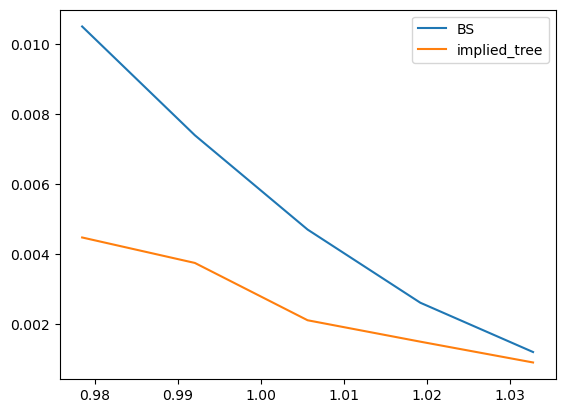

In [1039]:
percentage =np.linspace(0.05,0.1,5)
barrier = [S0*(1-i) for i in percentage]
BS_doput = [BS_barrier_pricer(S0,K,T,r,q,i,implied_vol(S0,N,K),rebate,"downout_put") for i in barrier]
tree_doput = [tree_barrier_pricer(stock_tree,K,i,N,rebate,"downout_put") for i in barrier]

plt.plot(barrier,BS_doput,label="BS")
plt.plot(barrier,tree_doput,label="implied_tree")
plt.legend()

In [1040]:
barrier,tree_doput

([1.0327925, 1.019203125, 1.0056137500000002, 0.9920243750000001, 0.978435],
 [0.0009002349582225464,
  0.0014952359529876666,
  0.0021077422144336086,
  0.003746870859258249,
  0.004475487115194245])

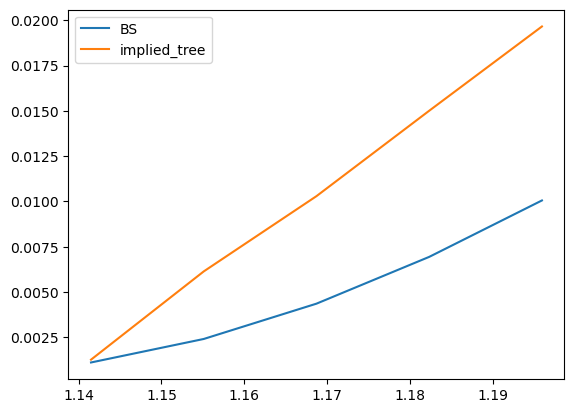

In [1041]:
barrier = [S0*(1+i) for i in percentage]
BS_upoutcall = [BS_barrier_pricer(S0,K,T,r,q,i,implied_vol(S0,N,K),rebate,"upout_call") for i in barrier]
tree_uocall = [tree_barrier_pricer(stock_tree,K,i,N,rebate,"upout_call") for i in barrier]

plt.plot(barrier,BS_upoutcall,label="BS")
plt.plot(barrier,tree_uocall,label="implied_tree")
plt.legend()

In [1042]:
barrier,tree_uocall

([1.1415075000000001,
  1.1550968750000001,
  1.16868625,
  1.182275625,
  1.1958650000000002],
 [0.0012673956022404916,
  0.0061395299310512165,
  0.010294586620866231,
  0.01500916603017141,
  0.01966078975839891])

below are some tests to see wether the tree price matches with market price

In [692]:
def get_strike_from_delta(delta,vol,T,S):
    d1 = norm.ppf(np.exp(q*T)*delta)
    K = S/np.exp(vol*np.sqrt(T)*d1-(r+vol**2/2)*T)
    return K

In [884]:
def BS_vanilla(K,T,vol,S0,r,q,optionType): #BS formula
    d1 = (np.log(S0/K) + (r-q+vol**2/2)*T)/(vol*np.sqrt(T))
    d2 = d1- vol*np.sqrt(T)
    if optionType == "call":
        return np.exp(-q*T)*S0*norm.cdf(d1)-np.exp(-r*T)*K*norm.cdf(d2)
    elif optionType == "put":
        return -np.exp(-q*T)*S0*norm.cdf(-d1)+np.exp(-r*T)*K*norm.cdf(-d2)

### delta 75

In [1046]:
delta = 0.75
vol = 0.1362
T = 180/360

strike = get_strike_from_delta(delta,vol,T,S0)
strike

1.0389789814117425

In [1047]:
tree_barrier_pricer(stock_tree,strike,5,N,rebate,"upout_call")

0.08057807276716882

In [1050]:
BS_vanilla(strike,T,vol,S0,r,q,"call")

0.08004248644283662

In [1049]:
BS_barrier_pricer(S0,strike,T,r,q,5,vol,rebate,"upout_call")

0.08004248644283662

### delta 25

In [1051]:
delta = 0.25
vol = 0.1062
T = 180/360
strike = get_strike_from_delta(delta,vol,T,S0)
strike

1.1641949704064882

In [1052]:
tree_barrier_pricer(stock_tree,strike,5,N,rebate,"upout_call")

0.010682637296188378

In [1053]:
BS_vanilla(strike,T,vol,S0,r,q,"call")

0.011733594502241762

In [1054]:
BS_barrier_pricer(S0,strike,T,r,q,5,vol,rebate,"upout_call")

0.011733594502241762

### delta 50

In [1055]:
delta = 0.50
vol = 0.115
T = 7/360
strike = get_strike_from_delta(delta,vol,T,S0)
strike

1.0879242282121104

In [1056]:
tree_barrier_pricer(stock_tree,strike,5,N,rebate,"upout_call")

0.04447500849300068

In [1057]:
BS_vanilla(strike,T,vol,S0,r,q,"call")

0.00688566894773579

In [1058]:
BS_barrier_pricer(S0,strike,T,r,q,5,vol,rebate,"upout_call")

0.00688566894773579

In [931]:
d1 = (np.log(S0/S0/0.95) + N*dt*(r-q+0.1**2/2))/(0.1*np.sqrt(N*dt))
norm.cdf(d1)*100

74.2434437073543